<div class="alert alert-warning">
이 노트북을 처음 열어보면 아마도 그림이나 표의 수식 등이 제대로 표시되지 않고 있을 것입니다. 이때는 오른쪽 상단의 "Not Trusted"버튼을 눌러서 나오는 안내창의 "Trust"를 선택해주세요. 노트북에 저장되어 있던 결과들이 제대로 표시될 것입니다. Jupyter Notebook이 아닌 Jupyter Lab 환경이라면 상단 "View" 메뉴의 "Activate Command Palette" 항목을 선택한 다음 "Trust Notebook"이라는 기능을 검색하여 실행하면 됩니다. 검색을 할 때에는 앞 글자 "tr"만 입력하여도 해당 항목이 나옵니다.
</div>

# 4. 통합

지금까지 3회에 걸쳐 작물모형의 기초가 되는 생체량 증가 모델링에서 시작하여, 식물의 생리를 좀 더 고려한 광합성의 구현, 한편으로는 이 모든 성장에 관련된 타이밍을 잡아주는 생물계절의 측면까지 개별적으로 살펴보았습니다. 이번 마지막 시간에는 이러한 조각들이 어떻게 하나의 모형으로 합쳐질 수 있는지 그 사례를 확인하며 워크샵을 마무리하겠습니다. 이를 위해 첫번째 시간에 잠깐 소개해드렸던 마늘모형으로 다시 돌아가보겠습니다.

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

In [3]:
using CSV
using DataFrames
using Dates
import Gadfly as G
using TimeZones

## 4.1. 마늘모형 (Garlic.jl)

예전에 소개해드렸듯이 Cropbox 기반으로 개발한 마늘모형은 [Garlic.jl](https://github.com/cropbox/Garlic.jl)이라는 이름의 Julia 패키지로 등록되어 있습니다. 모형의 토대가 되는 이론적인 부분은 [Hsiao *et al.* (2019)](https://doi.org/10.1093/aob/mcz060) 논문을 참고하시면 되고, 최근에 진행하였던 실험에 대해서는 현재 심사중인 [Yun *et al.* (2021)](https://doi.org/10.1101/2021.11.04.467009) 논문을 확인하시면 되겠습니다.

In [4]:
using Garlic

그럼 마늘모형의 전체 구조도를 다시 한번 그려보겠습니다.

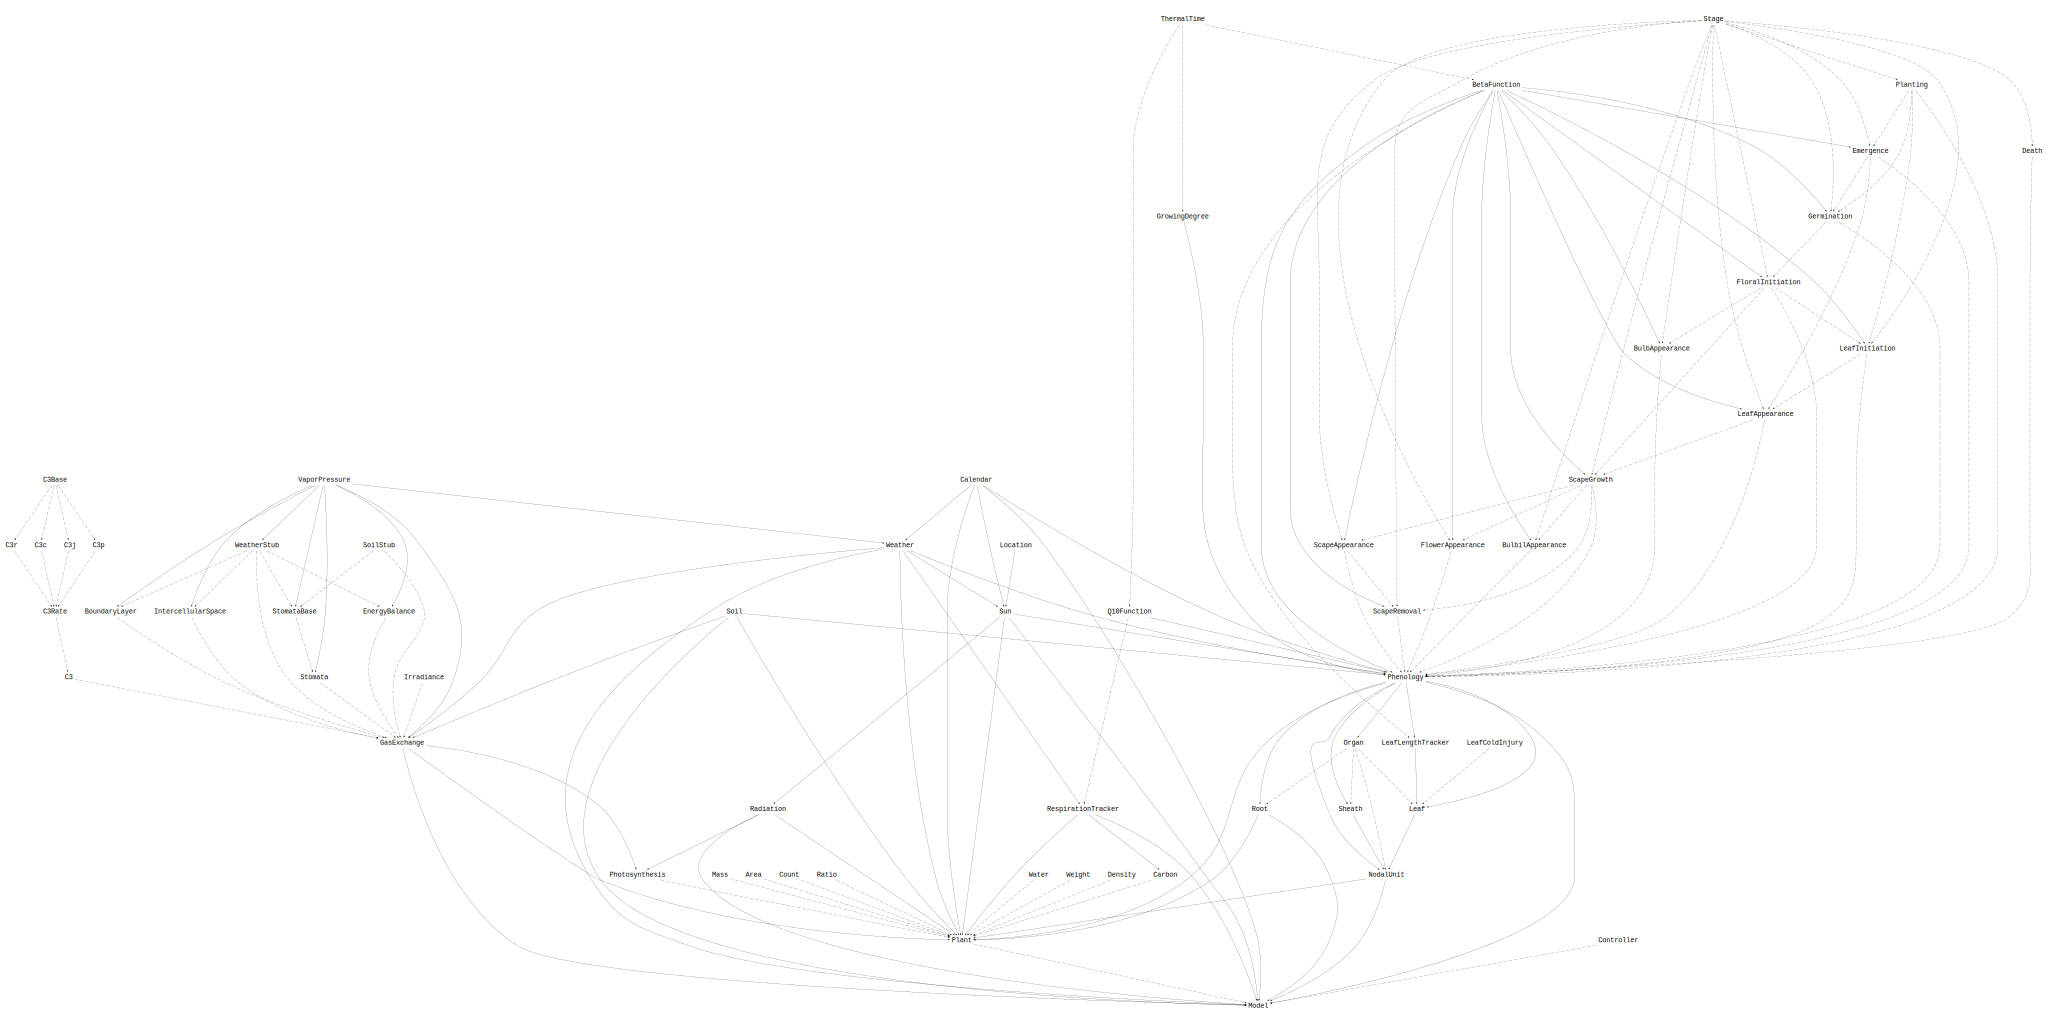

In [5]:
Cropbox.hierarchy(Garlic.Model; skipcontext = true)

여전히 크고 복잡해보이지만 유심히 들여다보면 수업에서 다루었던 부분들, 예를 들어 광합성을 구현하는 `GasExchange` 모형이 거의 그대로 들어가 있으며, 지난 시간에 보았던 `BetaFunction`이나 `GrowingDegree`도 생물계절을 담당하는 `Phenology`라는 시스템에서 많이 사용되고 있는 것을 확인할 수 있습니다. 이제 각 부분들을 워크샵에서 다루었던 주제의 역순으로 잘게 나누어 보겠습니다.

### 4.1.1. 생물계절

우선 생물계절(`Phenology`) 부분에 대해서만 다시 구조도를 그려보겠습니다. 발아(`Germination`), 출현(`Emergence`), 출엽(`LeafAppearance`) 등 식물의 각 성장 단계를 표현하는 시스템들이 여럿 보이는데 이들은 거의 공통적으로 `BetaFunction`을 믹스인으로 포함하고 있으며, 이는 구조도에서 실선으로 표현되어 있습니다. 

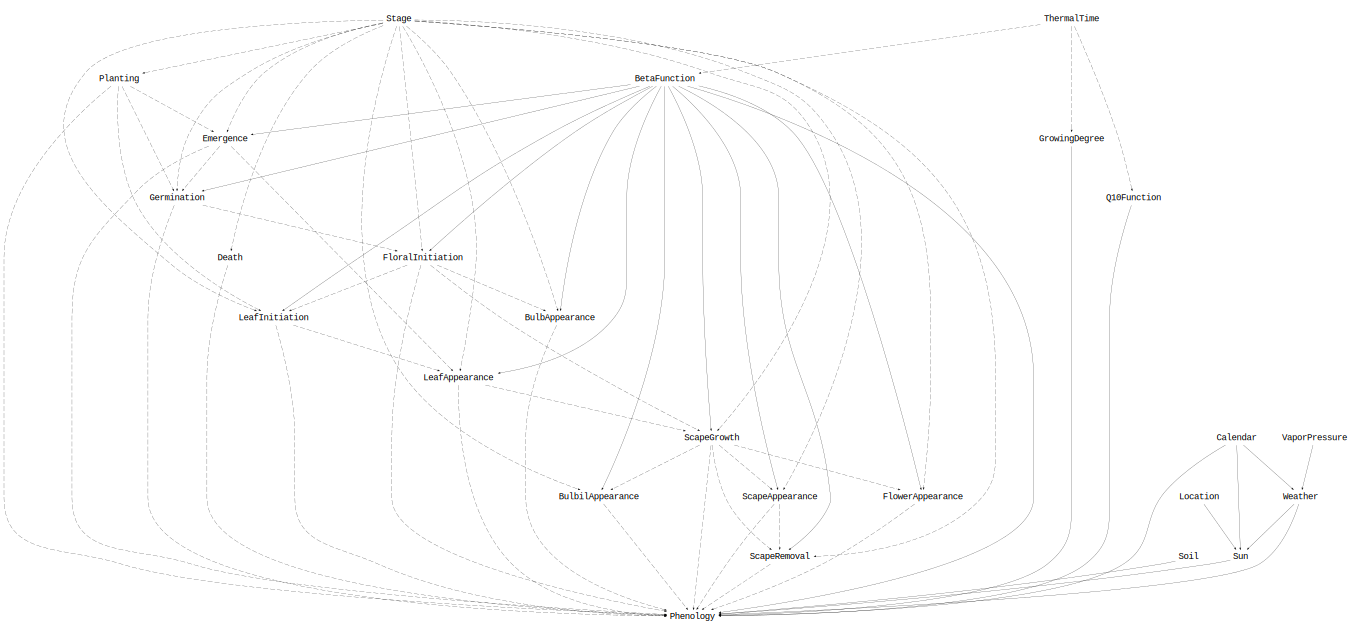

In [6]:
Cropbox.hierarchy(Garlic.Phenology; skipcontext = true)

그중에서 지난 시간에 직접 만들어보았던 출엽(`LeafAppearance`)이 어떻게 만들어져 있는지 들여다보겠습니다. Cropbox에서는 `source()` 함수를 사용하면 이미 만들어진 시스템의 명세를 확인해볼 수 있습니다.

In [7]:
Cropbox.source(Garlic.LeafAppearance)

quote
    #= /opt/julia/packages/Garlic/kvsj1/src/phenology/leafappearance.jl:2 =#
    LTARa_max:maximum_phyllochron_asymptote => 0.4421 ~ preserve(u"d^-1", parameter)
    #= /opt/julia/packages/Garlic/kvsj1/src/phenology/leafappearance.jl:3 =#
    _SDm => 117.7523 ~ preserve(u"d", parameter)
    #= /opt/julia/packages/Garlic/kvsj1/src/phenology/leafappearance.jl:4 =#
    _k => 0.0256 ~ preserve(u"d^-1", parameter)
    #= /opt/julia/packages/Garlic/kvsj1/src/phenology/leafappearance.jl:6 =#
    LTAR_max0(LTARa_max, SD, _SDm, _k):initial_maximum_phyllochron => begin
                #= /opt/julia/packages/Garlic/kvsj1/src/phenology/leafappearance.jl:7 =#
                LTARa_max / (1 + exp(-k * (SD - SDm)))
            end ~ preserve(u"d^-1", parameter)
    #= /opt/julia/packages/Garlic/kvsj1/src/phenology/leafappearance.jl:10 =#
    LTAR_max(LTAR_max0, LTARa_max, n = leaves_appeared, ng = leaves_generic):maximum_phyllochron => begin
                #= /opt/julia/packages/Garlic/kvsj1/s

그렇지만 아무래도 눈에 잘 들어오지는 않는 것 같으니 아래에 다시 적어보겠습니다. 지난 주에 만들었던 모형과는 달리 여러 변수들이 추가되어 있지만 핵심적인 부분만 추려보면 다음과 같습니다. Beta 함수로 계산한 단위시간당 출엽율(`r*β`)이 누적된 `LTA` 값이 초기에 가지고 있던 1장(`ILTA`)과 더해져서 현재 출엽수(`leaves_appeared`)가 되는 구조입니다. 코드는 조금 다르지만 개념적으로는 지난 주에 다루었던 것과 동일합니다.

```julia
@system LeafAppearance(Stage, Emergence, LeafInitiation) begin
    ..

    LTA(r = LTAR_max, β = BF.ΔT): leaf_tip_appearance => r*β ~ accumulate(when = leaf_appearing)

    ILTA: initial_leaf_tip_appearance => 1            ~ track::int(when = emerged)
    leaves_appeared(ILTA, LTA)        => (ILTA + LTA) ~ track::int(round = :floor)
    
    ..
end
```

그렇다면 Beta 함수에서 출엽율을 계산할 때 사용되는 `r`, 즉 최대출엽율(`LTAR_max`)는 어디서 오는 것일까요? 이전에 다루었던 모형에서는 모수로 정의하여 고정된 값을 설정으로 넣어주도록 처리하였는데요. 여기서는 조금 더 나아가게 됩니다. 저희가 마늘모형을 만들 때 진행하였던 실험에서 확인하였던 사실 중 하나가 마늘종구의 저장 상태(기간, 온도)에 따라 파종 이후 출엽율이 달라진다는 부분입니다. 저장을 오래하여 늦게 심은 종구에서 출엽이 더 빨리 진행되는 것이었는데요. 이를 표현하기 위해 최대출엽율(`LTAR_max`) 자체를 상수가 아닌 로지스틱 함수에 따라 변화하는 값으로 정의하게 되었습니다.

상세한 기술적인 내용보다는 모형 개발 초기에 `preserve(parameter)`로 정의되었던 `LTAR_max`가 이후에 필요에 의해 확장되어 `track`으로 바뀌었으며 이에 필요한 부수적인 변수들, 모수들이 추가되었다는 점, 그리고 이러한 수정을 위해 기존 코드가 크게 바뀌지는 않았다는 점에 주목해주세요.

```julia
@system LeafAppearance(Stage, Emergence, LeafInitiation) begin
    LTARa_max: maximum_phyllochron_asymptote => 0.4421   ~ preserve(parameter, u"d^-1")
    _SDm                                     => 117.7523 ~ preserve(parameter, u"d")
    _k                                       => 0.0256   ~ preserve(parameter, u"d^-1")

    LTAR_max0(LTARa_max, SD, _SDm, _k): initial_maximum_phyllochron => begin
        LTARa_max / (1 + exp(-k * (SD - SDm)))
    end ~ preserve(u"d^-1", parameter)

    LTAR_max(LTAR_max0, LTARa_max, n=leaves_appeared, ng=leaves_generic): maximum_phyllochron => begin
        n0 = 0
        r0 = LTAR_max0
        r1 = LTARa_max / 2
        r0 + (r1 - r0) * (clamp(n, n0, ng) - n0) / (ng - n0)
    end ~ track(u"d^-1")

    LTA(r = LTAR_max, β = BF.ΔT): leaf_tip_appearance => r*β ~ accumulate(when = leaf_appearing)

    ILTA: initial_leaf_tip_appearance => 1            ~ track::int(when = emerged)
    leaves_appeared(ILTA, LTA)        => (ILTA + LTA) ~ track::int(round = :floor)
    
    ..
end
```

나머지는 출엽이 가능한 상태인지 판단하는 `leaf_appearable`, 출엽이 완료되었는지 확인하는 `leaf_appeared`, 출엽이 진행중인지 나타내는 `leaf_appearing` 등의 `flag` 변수들입니다. 생물계절 관련 다른 단계에서 이러한 변수들을 확인하여 특정한 과정(process)을 진행하거나 멈출 수 있도록 연결해주는 고리가 됩니다. 여기서도 출**현**이 되었는지 확인하는 조건(`emerged`)이나 출엽 이전의 발생엽수(`leaves_initiated`) 등 다른 과정에서 계산된 변수들이 사용되는 것을 볼 수 있습니다. 이들은 `Emergence`와 `LeafInitiation` 등 해당 시스템을 믹스인으로 합쳐놓았기 때문에 접근이 가능해지는 구조입니다.

```julia
@system LeafAppearance(Stage, Emergence, LeafInitiation) begin
    LTARa_max: maximum_phyllochron_asymptote => 0.4421   ~ preserve(parameter, u"d^-1")
    _SDm                                     => 117.7523 ~ preserve(parameter, u"d")
    _k                                       => 0.0256   ~ preserve(parameter, u"d^-1")

    LTAR_max0(LTARa_max, SD, _SDm, _k): initial_maximum_phyllochron => begin
        LTARa_max / (1 + exp(-k * (SD - SDm)))
    end ~ preserve(u"d^-1", parameter)

    LTAR_max(LTAR_max0, LTARa_max, n=leaves_appeared, ng=leaves_generic): maximum_phyllochron => begin
        n0 = 0
        r0 = LTAR_max0
        r1 = LTARa_max / 2
        r0 + (r1 - r0) * (clamp(n, n0, ng) - n0) / (ng - n0)
    end ~ track(u"d^-1")

    LTA(r = LTAR_max, β = BF.ΔT): leaf_tip_appearance => r*β ~ accumulate(when = leaf_appearing)

    ILTA: initial_leaf_tip_appearance => 1            ~ track::int(when = emerged)
    leaves_appeared(ILTA, LTA)        => (ILTA + LTA) ~ track::int(round = :floor)
    
    leaf_appearable(emerged) ~ flag
    leaf_appeared(leaves_appeared, leaves_initiated) => begin
        0 < leaves_initiated <= leaves_appeared
    end ~ flag
    leaf_appearing(leaf_appearable & !leaf_appeared) ~ flag
end
```

그럼 이제 마늘모형의 생물계절 부분만 따로 떼어내서 모의를 수행해보겠습니다. 이를 위해 필요한 기상정보를 담당하는 `Weather`와 같은 공통 시스템들은 직접 만들어서 넣어주게 됩니다.

In [8]:
@system PhenologyController(Garlic.Phenology, Controller) begin
    calendar(context)               ~ ::Calendar

    weather(context, calendar)      ~ ::Garlic.Weather
    sun(context, calendar, weather) ~ ::Garlic.Sun
    soil(context)                   ~ ::Garlic.Soil
end

PhenologyController

테스트를 위해 `Garlic.jl` 패키지에 내장되어 있는 제주 고산(185)의 2010년 기상 자료를 이용하여 설정을 만들겠습니다. 파종일은 11월 1일입니다.

In [9]:
pheno_config = @config(
    :Calendar  => :init          => ZonedDateTime(2010, 10, 1, tz"Asia/Seoul"),
    :Weather   => :store         => Garlic.loadwea(Garlic.datapath("Korea/185_2010.wea"), tz"Asia/Seoul"),
    :Phenology => :planting_date => ZonedDateTime(2010, 11, 1, tz"Asia/Seoul"),
)

Config for 3 systems:
  Calendar
    init = ZonedDateTime(2010, 10, 1, tz"Asia/Seoul")
  Weather
    store = 8760×10 DataFrame…
  Phenology
    planting_date = ZonedDateTime(2010, 11, 1, tz"Asia/Seoul")

출엽수(`leaves_appeared`)를 발생엽수(`leaves_initiated`)와 함께 그려보겠습니다. 대략 10개월(300일)에 대한 모의입니다.

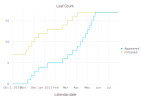

In [10]:
visualize(PhenologyController, "calendar.date", [:leaves_appeared, :leaves_initiated];
    config = pheno_config,
    stop = 300u"d",
    snap = 1u"d",
    title = "Leaf Count",
    names = ["Appeared", "Initiated"],
    kind = :line,
)

열 시간(thermal time)에 기반한 Beta 함수를 사용하기 때문에 출엽 간격이 짧을 때도 있고 길 때도 있습니다. 특히 1월과 2월 사이에는 그 기간이 특히 길었는데, 그 원인은 기온(`T`) 그래프를 확인해보면 알 수 있습니다.

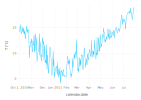

In [11]:
visualize(PhenologyController, "calendar.date", :T;
    config = pheno_config,
    stop = 300u"d",
    snap = 1u"d",
    kind = :line,
)

모형이 내부적으로 거치게 되는 좀 더 거시적인 생물계절 관련 단계는 `development_phase` 변수를 통해 확인할 수 있습니다. 11월 초 파종 이후 시작된 영양생장(`vegetative`) 단계가 4월초에 끝날 때까지 엽 발달이 지속되는 것을 확인할 수 있으며, 이렇게 나온 잎들이 모두 출엽하는 것은 5월 중순경이라는 것을 위의 그래프에서 확인하였습니다. 그리고 이 시기는 작물이 이미 생식생장(`bulb_growth_before_scape_appearance`)으로 넘어간 상태입니다. 쫑(scape)은 6월 초에 드러나게 되는데 이때 제거를 할 것인지 결정할 수도 있으며, 이는 이후 동화산물 분배에 영향을 끼치게 되는 구조입니다.

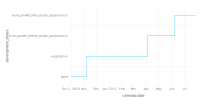

In [12]:
visualize(PhenologyController, "calendar.date", :development_phase;
    config = pheno_config,
    stop = 300u"d",
    snap = 1u"d",
    kind = :step,
)[] |> G.SVG(8G.inch, 4G.inch)

실제 작물모형에서 다루는 여러가지 생물계절 단계들은 여러 상호작용을 고려해야 하기 때문에 복잡해보이지만, 하나씩 뜯어보면 간단한 열 시간(thermal time) 모형에 근거하는 경우가 많으며, 결국 이들을 잘 연결해주는 것이 더 중요하다는 점을 확인하였습니다.

### 4.1.2. 광합성

다음은 2주차에 다루었던 광합성, 그중에서도 특히 기공전도도(stomatal conductance)와 에너지 균형(energy balance)이 모두 엮여 있는 기체교환 모형이 어떻게 사용되는지 확인해보도록 하겠습니다. 당시 살펴보았던 기체교환 모형은 거의 동일한 구조 그대로 `GasExchange` 시스템에 구현되어 있습니다. 해당 모형은 개별 엽 단위(leaf level)로 작동하기 때문에 이를 작물 전체(canopy) 규모로 확장(scale up)해줄 필요가 있습니다. 특히 작물 내 위치별 광량의 차이가 클 수 있기 때문에 이를 다루는 `Radiation` 시스템이 추가되어 `Photosynthesis` 시스템을 구성하고 있습니다.

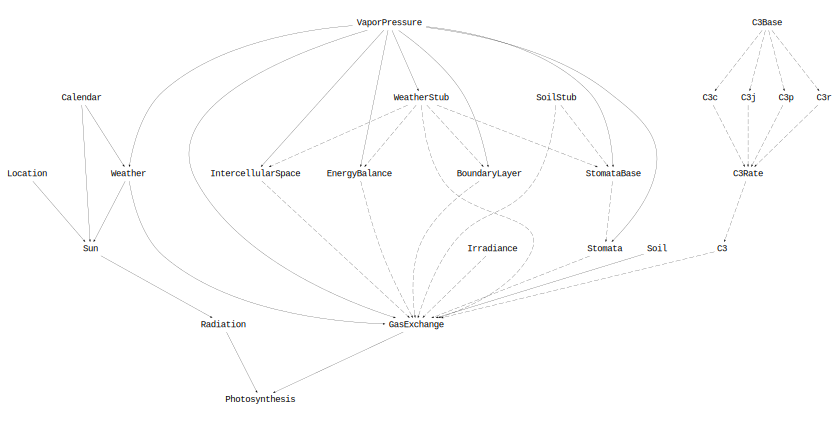

In [13]:
Cropbox.hierarchy(Garlic.Photosynthesis; skipcontext = true)

`Radiation` 시스템은 작물의 광합성이 크게 두가지의 광 조건, 즉 직광(sunlit)과 음영(shaded) 조건에서 이루어진다고 가정하고 해당 광량을 계산하는 역할을 맡습니다. 이와 관련한 보다 자세한 내용은 [De Pury and Farquhar (1997)](https://doi.org/10.1111/j.1365-3040.1997.00094.x) 논문에서 확인하실 수 있습니다. 마늘모형에서는 두개의 독립적인 `GasExchange` 시스템을 만든 다음, `Radiation`에서 두 조건에 대해 계산된 각각의 광량(`Q_sun`, `Q_sh`)과 LAI(`LAI_sunlit`, `LAI_shaded`)를 넣어서 구동하는 구조로 되어 있습니다. 이때 작물 전체의 순광합성율(`A_net`)은 각 `GasExchange`에서 개별 계산된 `A_net`을 `LAI` 비율에 맞추어 더해주는 것으로 구하게 됩니다.

```julia
@system Photosynthesis begin
    ..
   
    radiation(context, sun, leaf_area_index) ~ ::Radiation

    sunlit_gasexchange(context, soil, weather, PPFD = Q_sun, LAI = LAI_sunlit) ~ ::GasExchange
    shaded_gasexchange(context, soil, weather, PPFD = Q_sh,  LAI = LAI_shaded) ~ ::GasExchange

    LAI_sunlit(radiation.sunlit_leaf_area_index): sunlit_leaf_area_index ~ track
    LAI_shaded(radiation.shaded_leaf_area_index): shaded_leaf_area_index ~ track

    Q_sun(radiation.irradiance_Q_sunlit): sunlit_irradiance ~ track(u"μmol/m^2/s")
    Q_sh(radiation.irradiance_Q_shaded):  shaded_irradiance ~ track(u"μmol/m^2/s")

    A_net(
        a = sunlit_gasexchange.A_net_total,
        b = shaded_gasexchange.A_net_total,
    ): net_CO2_umol_per_m2_s => a + b ~ track(u"μmol/m^2/s")

    ..
end
```

이번에도 광합성(`Photosynthesis`) 부분만 따로 분리하여 모의를 진행해보겠습니다. 필요한 공통 시스템과 일부 모수들도 넣어줍니다.

In [14]:
@system PhotosynthesisController(Garlic.Photosynthesis, Garlic.Weight, Garlic.Water, Controller) begin
    calendar(context)                ~ ::Calendar

    weather(context, calendar)       ~ ::Garlic.Weather
    sun(context, calendar, weather)  ~ ::Garlic.Sun
    soil(context)                    ~ ::Garlic.Soil

    LAI(LAI0): leaf_area_index       ~ track(u"m^2/m^2")
    LAI0:      leaf_area_index_param ~ preserve(parameter, u"m^2/m^2")
    PD:        plant_density         ~ preserve(parameter, u"m^-2")
end

PhotosynthesisController

기상자료는 생물계절 예제와 마찬가지로 제주 고산 지역의 2010년 자료를 활용합니다. 엽면적지수(leaf area index; `LAI`)와 개체밀도(plant density; `PD`)는 실제 모형에서는 고정된 값이 아니라 생장에 따라 변화하는 값이지만, 여기서는 광합성 부분만 떼어냈기 때문에 값을 별도로 계산할 수 없어 상수값을 넣어주도록 합니다.

In [15]:
photo_config = @config(
    :Calendar                 => :init  => ZonedDateTime(2010, 10, 1, tz"Asia/Seoul"),
    :Weather                  => :store => Garlic.loadwea(Garlic.datapath("Korea/185_2010.wea"), tz"Asia/Seoul"),
    :PhotosynthesisController => (:LAI0 => 5, :PD => 55),
)

Config for 3 systems:
  Calendar
    init = ZonedDateTime(2010, 10, 1, tz"Asia/Seoul")
  Weather
    store = 8760×10 DataFrame…
  PhotosynthesisController
    LAI0 = 5
    PD   = 55

우선 단위면적당 순광합성율(`A_net`)이 어떻게 나오는지 보겠습니다. 여기서 면적은 개별 잎의 엽면적이 아니라 작물이 심어져 있는 대지를 기준으로 합니다. 광합성율을 계산할 때 각 환경조건(sunlit, shaded)에 따른 LAI가 고려되었기 때문입니다. 참고로, 여기서 계산하는 광합성율은 실제 마늘이 10월 1일에 심어졌을 때를 기준으로 모의하는 것이 아니라 위에서 설정으로 넣어준 특정 `LAI`와 `PD` 값을 기준으로 나오는 것입니다. 지금은 마늘모형 전체를 돌리는 것이 아니라 광합성 부분만 따로 떼어낸 다음 임의로 실험해보는 중이라는 점 잊지 말아주세요.

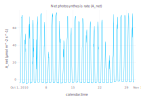

In [16]:
visualize(PhotosynthesisController, "calendar.time", :A_net;
    config = photo_config,
    stop = 30u"d",
    title = "Net photosynthesis rate (A_net)",
    kind = :line,
)   

이러한 순광합성율을 직광(sunlit)과 음영(shaded)의 두가지 조건으로 분리해보면 아래와 같습니다.

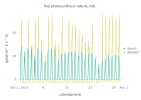

In [17]:
visualize(PhotosynthesisController, "calendar.time", [
        "sunlit_gasexchange.A_net_total",
        "shaded_gasexchange.A_net_total",
    ];
    config = photo_config,
    stop = 30u"d",
    title = "Net photosynthesis rate (A_net)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

기간이 길어서 잘 보이지 않으니 처음 3일만 따로 표시해보겠습니다.

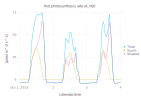

In [18]:
visualize(PhotosynthesisController, "calendar.time", [
        :A_net,
        "sunlit_gasexchange.A_net_total",
        "shaded_gasexchange.A_net_total",
    ];
    config = photo_config,
    stop = 3u"d",
    title = "Net photosynthesis rate (A_net)",
    names = ["Total", "Sunlit", "Shaded"],
    kind = :line,
)   

이와 유사하게 LAI 값도 분리해볼 수 있습니다. 앞에서 설정으로 넣어준 고정 값은 5였는데 이 값은 계절에 따라, 그리고 하루동안에도 태양의 고도에 따라 직광(sunlit)과 음영(shaded)이 차지하는 비율이 계속 달라지게 됩니다.

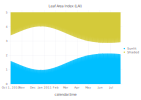

In [19]:
visualize(PhotosynthesisController, "calendar.time", [
        "radiation.LAI_sunlit",
        "radiation.LAI_shaded",
    ];
    config = photo_config,
    stop = 300u"d",
    title = "Leaf Area Index (LAI)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

예를 들어 한겨울인 1월 1일에는 태양의 고도가 낮아서 직광(sunlit)의 비율이 상대적으로 낮은 것을 확인할 수 있습니다.

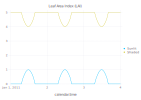

In [20]:
visualize(PhotosynthesisController, "calendar.time", [
        "radiation.LAI_sunlit",
        "radiation.LAI_shaded",
    ];
    config = (photo_config, :Calendar => :init  => ZonedDateTime(2011, 1, 1, tz"Asia/Seoul")),
    stop = 3u"d",
    title = "Leaf Area Index (LAI)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

이와 반대로 한여름인 7월 1일에는 그 비율이 상대적으로 올라가는 것을 볼 수 있습니다. 하루동안 해가 뜨고 지는 것에 따라 그 비율이 바뀌는 것도 함께 보입니다.

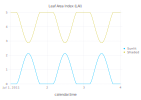

In [21]:
visualize(PhotosynthesisController, "calendar.time", [
        "radiation.LAI_sunlit",
        "radiation.LAI_shaded",
    ];
    config = (photo_config, :Calendar => :init  => ZonedDateTime(2011, 7, 1, tz"Asia/Seoul")),
    stop = 3u"d",
    title = "Leaf Area Index (LAI)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

이러한 LAI의 비율에 따라 전체 입사광이 직광(sunlit)과 음영(shaded)으로 분배되는 양을 계산해보면 아래와 같습니다. 여기서 나오는 광량이 바로 두개의 독립적인 `GasExchange` 시스템에서 사용하는 값이 되는 것입니다. 이후 기체교환 모형이 구동되는 방식은 2주차에서 이미 살펴본 것과 동일합니다.

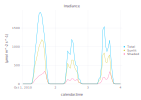

In [22]:
visualize(PhotosynthesisController, "calendar.time", ["radiation.sun.PARtot", :Q_sun, :Q_sh];
    config = photo_config,
    stop = 3u"d",
    title = "Irradiance",
    names = ["Total", "Sunlit", "Shaded"],
    kind = :line,
)   

### 4.1.3. 생체량

#### 4.1.3.1. 성장률

이제 워크샵 처음 1주차에 다루었던 내용으로 다시 돌아갑니다. 생체량(biomass) 성장 곡선을 맞추기 위해서 로직스틱(logistic)이나 곰퍼츠(Gompertz) 함수를 사용했던 것 기억나시나요? 그때는 전체 곡선을 하나의 함수로 표현하려고 했지만, 실제 작물모형에서의 생체량은 그렇게 함수 하나로 표현되는 값이 아니라 여러가지 과정(process)들이 상호작용한 결과로 창발하는 속성(emergent property)인 경우가 많습니다.

In [23]:
sim = simulate(Garlic.Model;
    config = Garlic.Examples.RCP.ND_RICCA_2014_field,
    stop = "calendar.count",
);

Progress: 100%[===========================] Time: 0:02:21 (21.65 ms/it)/it)


우선 마늘모형을 돌려서 총생체량이 어떻게 변화하는지 확인해보겠습니다. 2014년 제주 온난화대응농업연구소의 노지에서 남도 품종을 재배하였을 때의 조건입니다. 어떻게 보면 지수적으로 생장하다가 마지막에 멈춘 것 같기도 하고, 곰퍼츠 함수처럼 완만하게 누워있는 것 같기도 한 곡선을 확인할 수 있습니다. 하지만 이 총생체량은 그런 함수들로 직접 계산된 값이 아닙니다.

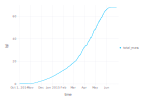

In [24]:
visualize(sim, :time, :total_mass; kind = :line)

참고로, 총생체량은 내부적으로 작물의 각 부위에 배분된(partitioning) 생체량의 합으로 표현할 수도 있습니다. 이중에서 구(bulb)에 배분되는 생체량이 바로 마늘의 수량(yield)이라고 볼 수 있겠습니다.

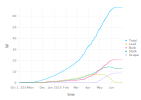

In [25]:
visualize(sim, :time, [:total_mass, :living_leaf_mass, :bulb_mass, :living_stalk_mass, :visible_scape_mass];
    kind  = :line,
    names = ["Total", "Leaf", "Bulb", "Stalk", "Scape"],
)

아무튼 총생체량(total biomass)의 계산에는 여러 요인들이 영향을 끼치고 있습니다만, 여기서는 그중에서 가장 직접적인 역할을 한다고 볼 수 있는 단위시간당 가용 동화산물량(`total_carbon`)을 살펴보겠습니다. 이 값은 앞의 광합성 과정에서 나오는 대지면적당 총광합성율(`A_gross`)을 작물의 개체밀도에 맞게 배분하여 작물 개체 기준으로 변환한 다음 호흡이나 변환효율 등을 고려하여 계산합니다. 작물 전체 기준, 단위시간당 증가(혹은 감소)하는 생체량이며 실제 바로 위 그래프에서 각 부위별로 배분할 때 기준이 되는 값이기도 합니다.

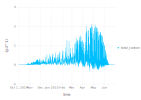

In [26]:
visualize(sim, :time, :total_carbon; kind = :line)

이러한 단위시간당 가용 동화산물량을 해당 시점의 총생체량으로 나누면 바로 저희가 1주차, 2주차에 계속 고민하였던 성장률(growth rate; `r`)으로 변환할 수 있습니다. 처음에 고정된 성장률 값을 사용하여 지수적 성장을 표현해본 다음, 확인된 문제점을 해결하기 위해 성장률 값을 시간에 따라 줄이는 방법에 대해 계속 고민했던 것을 기억하시나요? 마늘모형에서는 오히려 성장률이라는 개념이 따로 들어있지 않기 때문에 이 값을 직접 계산해서 아래와 같이 표현해볼 수 있습니다. 역시 기대했던 것처럼 전반적으로 감소하는 패턴을 확인할 수 있습니다. 하지만 환경조건에 따라 혹은 작물의 성장 단계에 따라 여러가지 요건에 의해 그 값이 동적으로 변화하는 것이 보입니다. 이처럼 창발적으로 나타나는 속성을 들여다보고 이해하는 것이 과정 기반 모형(process-based model)을 사용하는 묘미라고도 생각합니다.

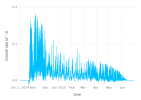

In [27]:
visualize(sim, :time, :(total_carbon / total_mass);
    kind = :line,
    ylab = "Growth rate",
    name = "",
    ylim = (-0.01, 0.2),
)

#### 4.1.3.2. 엽 생장

위의 단위시간당 가용 동화산물량(`total_carbon`)을 계산할 때 근간이 되는 값은 단위시간당 생성되는 동화산물량(`carbon_supply`)입니다.

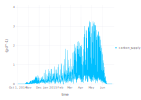

In [28]:
visualize(sim, :time, :carbon_supply; kind = :line)

이러한 동화산물 생산율은 광합성율과 매우 밀접한 관련이 있습니다.

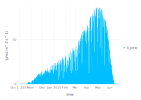

In [29]:
visualize(sim, :time, :A_gross; kind = :line)

그리고 대지기준 단위면적당 광합성율을 결정할 때 중요한 역할을 하는 것이 바로 엽면적지수(leaf area index)입니다. 단위 엽면적당 광합성을 결정하는 것은 환경요인이지만 그렇게 결정된 값이 작물 단위로, 대지면적 단위로 확장될 때에는 이 엽면적지수를 따르기 때문입니다. 실제 엽면적지수는 위의 광합성율과 상당히 유사한 모양을 하고 있습니다.

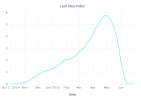

In [30]:
visualize(sim, :time, :LAI;
    title = "Leaf Area Index",
    name = "",
    kind = :line,
)

그리고 엽면적지수는 총엽면적을 해당 대지면적으로 나눈 값으로 정의됩니다. 대지면적은 고정되어 있기 때문에 결국 그 양상은 총엽면적과 같다고 볼 수 있습니다.

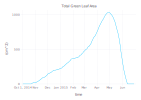

In [31]:
visualize(sim, :time, :green_leaf_area;
    title = "Total Green Leaf Area",
    name = "",
    kind = :line,
)

그렇다면 이 총엽면적은 어떻게 계산할까요? 사실 작물에 따라, 그리고 작물모형에 따라 다양한 접근 방식이 있을 수 있습니다. 상당수의 작물모형들, 특히 기체교환 과정을 상세히 구현하지 않는 경우에는 엽면적을 별도로 모의하지 않는 대신, 이미 계산된 생체량에 고정된 SLA(specific leaf area)를 곱하여 구하기도 합니다. 하지만 저희 마늘모형에서는 광합성을 중요하게 다루기 때문에 엽면적을 별도로 구현하며, 이를 위해 개별 엽 단위의 생장을 모의한 다음 총 면적을 구하는 접근을 취하고 있습니다.

In [32]:
plot_leaves(v;
    config = Garlic.Examples.RCP.ND_RICCA_2014_field,
    index = :time,
    target = [],
    stop = "calendar.count",
    snap = 1u"d",
    legend = "Rank",
    kw...
) = begin
    r = simulate(Garlic.Model;
        config, index, target, stop, snap,
        snatch = (D, s) -> begin
            for nu in s.NU
                D[end][Symbol(nu.rank')] = nu.leaf[v]'
            end
        end
    )
    n = ncol(r) - 1 - length(target)
    visualize(r, index, string.(1:n); legend, kw...)
end

plot_leaves (generic function with 1 method)

그러면 개별 엽 단위에서 계산되는 엽면적을 확인해보겠습니다. 개별 잎은 각각의 노드(nodal unit)에 포함되어 있는 구조이며, 생물계절과 관련하여 결정된 발생시기에 따라 각자의 일정으로 생육을 진행합니다. 엽의 위치에 따라 최종 엽 길이, 즉 면적이 결정되며 이에 따라 다양한 면적의 엽 발생을 모의할 수 있습니다. 첫번째 엽면적은 `NU[1].leaf.area` 변수로 접근이 가능한데, 여러 잎에 대한 접근을 쉽게 하기 위해서 위에서 만든 `plot_leaves()` 함수를 활용하겠습니다.

Progress: 100%[===========================] Time: 0:00:40 ( 6.15 ms/it)


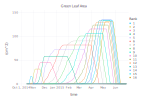

In [33]:
plot_leaves(:green_area;
    title = "Green Leaf Area",
    kind = :line,
    ylim = (0, 150),
)

총 16장의 엽수를 기준으로 각각의 엽면적 증가, 유지, 그리고 노화 과정을 확인할 수 있습니다. 각 엽의 순위(rank)는 처음 나온 잎에 1을 할당하고 이후 하나씩 증가하게 되어 있습니다. 전반적으로 늦게 나온 잎이 더 크게 자라는 것을 확인할 수 있으며, 전체 엽면적이 큰 경우 성숙 이후 유지되는 기간(stay green)이 상대적으로 길어진다는 특징도 보입니다.

내부적으로는 엽 면적이 바로 계산되는 것은 아니고, 실제로는 길이 생장(elongation)이 Beta 함수 기반의 적산 방식으로 구현되어 있으며, 이렇게 계산된 길이 값에 정해진 규칙(allometric)을 적용하여 면적을 구하도록 되어 있습니다.

Progress: 100%[===========================] Time: 0:00:39 ( 5.99 ms/it)


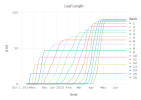

In [34]:
plot_leaves(:length;
    title = "Leaf Length",
    kind = :line,
    ylim = (0, 100),
)

각 엽의 최종길이(potential length)는 해당 시점까지 발생한 엽수를 기준와 해당 엽의 위치(rank)를 기준으로 동적으로 변화합니다. 마늘의 엽 생장 모형에 대한 보다 상세한 내용은 [Hsiao *et al.* 2019](https://doi.org/10.1093/aob/mcz060) 논문을 확인해주시기 바랍니다. 아무쪼록 각 구성 요소들이 나름의 기작을 가지고 구현되어 있으며, 이들이 한데 모여 결합되면서 다양한 결과를 내어줄 수 있다는 점을 말씀드리고 싶습니다.

Progress: 100%[===========================] Time: 0:00:13 ( 2.09 ms/it)


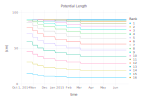

In [35]:
plot_leaves(:potential_length;
    title = "Potential Length",
    kind = :line,
    ylim = (0, 100),
)

그리고 엽 길이생장에 한가지 중요한 모수가 관여를 하게 되는데요. '최장엽의 최소길이'(minimum length of longest leaf; `LM_min`)이라는 조금 복잡한 이름을 가지고 있습니다. 엽수가 많아지면 해당 값보다 조금 더 길어지도록 조정이 되기는 하지만, 길이생장에서 다다를 수 있는 최대길이를 결정하는 중요한 모수입니다. 이 모수의 변화에 따라 실제 관측자료와 모형의 차이가 어떻게 달라지는지 비교해보도록 하겠습니다.

In [36]:
obs = CSV.read(Garlic.datapath("Korea/ricca_2014_field.csv"), DataFrame) |> unitfy;

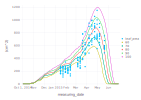

In [37]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim = (DateTime(2014, 10, 1), DateTime(2015, 6, 30)),
    ylim = (0, 1200),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config = Garlic.Examples.RCP.ND_RICCA_2014_field,
    stop = "calendar.count",
    snap = 1u"d",
    group = :Leaf => :LM_min => [60, 70, 80, 90, 100],
    kind = :line,
)

### 4.1.4. 응용

방금 전에 특정 범위 내의 `LM_min` 값을 바꿔가면서 모형을 여러번 구동하여 결과를 비교하는 것은 일종의 민감도 분석(sensitivity analysis)이라고 볼 수 있는데요. 여기서는 이를 응용하여 기후변화 연구에 적용한 사례를 간략하게 살펴보겠습니다. 대개 지역마다 최적의 파종일(planting date)이 정해져있는데 기후변화 시나리오 내에서 이러한 파종일을 유지해도 되는지, 혹은 최적 파종일이 바뀔 가능성이 있는지 모형을 통해 확인해보는 것입니다.

예를 들어, 2014년 제주 온난화대응농업연구소 기상조건에서 남도 품종을 기준으로 몇가지 파종일을 비교해봤을 때의 결과는 아래와 같습니다.

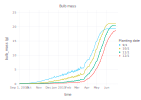

In [38]:
visualize(Garlic.Model, :time, :bulb_mass;
    config = (
        Garlic.Examples.RCP.ND_RICCA_2014_field,
        :Calendar => :init => ZonedDateTime(2014, 9, 1, tz"Asia/Seoul")
    ),
    stop = "calendar.count",
    snap = 1u"d",
    group = :Phenology => :planting_date => [
        ZonedDateTime(2014,  9, 1, tz"Asia/Seoul"),
        ZonedDateTime(2014, 10, 1, tz"Asia/Seoul"),
        ZonedDateTime(2014, 11, 1, tz"Asia/Seoul"),
        ZonedDateTime(2014, 12, 1, tz"Asia/Seoul"),
    ],
    title = "Bulb mass",
    legend = "Planting date",
    names = ["9/1", "10/1", "11/1", "12/1"],
    kind = :line,
    ylim = (0, 25),
)

수확시기를 어떻게 잡느냐에 따라 다르기는 하지만, 해당 지역에서 일반적으로 통용되는 5월 중순을 기준으로 보면 이른 파종이 유리한 것으로 모의되는 것을 확인할 수 있습니다. 같은 방식으로 미래 기후자료에 적용하면 앞서 얘기하였던 최적 파종일에 대한 실험을 모형으로 진행해볼 수 있습니다. 관련 내용은 현재 심사중인 [Yun *et al.* 2020](https://doi.org/10.1101/2021.11.04.467009) 논문에 포함되어 있는데 아래에 간단히 소개해드립니다.

#### 4.1.4.1. 지역

우선 국내의 두 지역을 선정하였습니다. 첫번째는 제주도 서부 고산 지역으로 현재 남도 마늘을 상업적으로 재배하는 지역입니다. 두번째는 강원도 춘천으로 추운 겨울의 동해로 인해 난지형 마늘을 재배하지 못하는 지역입니다. 각 지역의 평년, RCP4.5, RCP8.5 시나리오 기상자료를 이용하여 8월말부터 12월 중순까지 10일 간격의 파종일을 설정하여 모의를 진행하였습니다.

<img src="https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F2.large.jpg" width="300">

#### 4.1.4.2. 수량 예측 (고산)

![](https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F8.large.jpg)

#### 4.1.4.3. 수량 예측 (춘천)

![](https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F9.large.jpg)

#### 4.1.4.4. 최적 파종일

![](https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F10.large.jpg)

## 4.2. 정리

이상 마늘모형을 이용하여 지금까지 워크샵에서 다루었던 요소들이 어떤 방식으로 실제 작물모형에 통합될 수 있는지 살펴보았습니다. 더불어 이러한 모형을 가지고 수행해볼 수 있는 연구사례도 간략히 소개해드렸습니다. 물론 여기서 소개해드린 내용은 작물모형이라는 주제로 묶일 수 있는 내용의 극히 일부이며, 이외에도 다양한 주제, 그리고 다른 방식의 접근이 있을 수 있다는 점을 말씀드리고 싶습니다. 보다 중요한 것은 작물모형이 어렵고 복잡한 블랙박스 만은 아니라는 점, 그리고 또한 모든 것에 대한 답을 내어주는 요술상자도 아니라는 점을 이해하는 부분이라고 생각합니다. 아무쪼록 이번 워크샵이 작물모형에 대한 지속적인 관심과 연구로 이어질 수 있기를 바랍니다.

끝으로 워크샵이 개최될 수 있도록 이끌어주신 국립원예특작과학원 온난화대응농업연구소 문경환 연구관님, 워크샵 사전준비부터 진행에 도움을 주신 신민지 연구사님, 이성은 연구사님, 정선우 박사님, 김병혁 박사님, USDA-ARS 서범석 박사님, 그리고 매시간 특별강의를 해주신 워싱턴대학교 김수형 교수님께 감사의 말씀드립니다.

<p style="text-align: center;">
<img src="https://github.com/cropbox/Cropbox.jl/raw/main/docs/src/assets/logo.svg" width="200">
</p>


## 4.3. 뿌리모형 (BONUS)

여기부터는 특별부록입니다. Cropbox 프레임워크는 애초에 전통적인 과정 기반(process-based)의 작물모형을 개발하기 위해 도구로써 설계되었고, 지금까지도 관련 분야에서 주로 활용해온 것도 사실입니다만, 그렇다고 다른 방향으로의 확장이 막혀있는 것은 아닙니다. 여기서는 그러한 사례의 하나로써 구조기능모형(functional-structural plant model; FSPM)으로의 적용을 보여드리고자 합니다.

기술적으로는 모의 도중에 새로운 시스템의 인스턴스를 만들어내어 붙일 수 있는 `produce` 변수를 적극 활용하여 식물의 구조를 표현하는 단위들을 지속적으로 추가하는 것에 중점을 두고 있습니다. 이러한 구조를 적용할 수 있는 대표적인 분야가 바로 뿌리 구조모형인데요. 뿌리 가닥을 구성하는 조그만 조각들을 하나의 시스템으로 두고, 이를 계속 새로 만들어 붙이는 것으로 뿌리의 생장을 표현하는 것이죠. 기존에 이러한 접근을 보여준 모형이 몇몇 존재하는데, 이중에서 [CRootBox](https://plant-root-soil-interactions-modelling.github.io/CRootBox/)라는 모형의 알고리즘을 Cropbox 내에서 유사하게 구현한 [CropRootBox.jl](https://github.com/cropbox/CropRootBox.jl)를 소개합니다. 참고로 모두 상자(box)를 좋아하고 서로 이름도 비슷하지만 아무 관계는 없습니다.

In [39]:
using CropRootBox

### 4.3.1. 설정

아래 예제의 뿌리 구조(root system architecture)는 primary root, first order lateral root, second order lateral root의 세가지 종류의 조각(segment)으로 구성되어 있습니다.

모의 시작 최초에 존재하는 primary root의 개수는 설정(`maxB`)으로 정의합니다. 뿌리 조각이 성장하여 일정 크기가 되면, 새로운 조각이 만들어져서 기존의 조각에 붙게 됩니다. 이때 동일한 뿌리 종류를 유지하며 길이 생장을 표현하는 조각이 있고, 측면에서 새로운 종류의 뿌리를 만들어 가지를 치는 형태의 조각이 있습니다. 어떤 종류의 조각이 생성되는지는 역시 모수로 들어가는 전환표(transition table; `T`)를 기준으로 정해집니다. 각 조각들은 생장에 관련된 여러 모수들, 예를 들어, 길이와 관련한 모수로써 뿌리 줄기 하단부의 기저(basal) 영역의 길이를 나타내는 `lb`, 상단부의 축성(axial) 영역의 길이를 나타내는 `la`, 새로운 가지(branch)가 나오는 간격 `ln`, 각도(branching angle) `θ`, 길이생장률(elongation rate) `r` 등을 포함하고 있습니다.

이중 일부 모수의 값들은 확률에 의거한 표준변차를 표현하기 위해 `±` 기호를 사용하여 정의되어 있습니다. 이러한 값들은 해당 시스템이 처음 만들어질 때 주사위를 굴리듯 실제 값을 결정하도록 되어 있습니다. 이러한 확률적인 요소는 모형이 보다 사실적인 뿌리 구조를 만들어낼 수 있도록 도와줍니다.

In [40]:
root_maize = @config(
    :RootArchitecture => :maxB => 5,
    :BaseRoot => :T => [
        # P F S
          0 1 0 ; # P
          0 0 1 ; # F
          0 0 0 ; # S
    ],
    :PrimaryRoot => (;
        lb    = 0.1 ± 0.01,
        la    = 18.0 ± 1.8,
        ln    = 0.6 ± 0.06,
        lmax  = 89.7 ± 7.4,
        r     = 6.0 ± 0.6,
        Δx    = 0.5,
        σ     = 10,
        θ     = 80 ± 8,
        N     = 1.5,
        a     = 0.04 ± 0.004,
        color = CropRootBox.RGBA(1, 0, 0, 1),
    ),
    :FirstOrderLateralRoot => (;
        lb    = 0.2 ± 0.04,
        la    = 0.4 ± 0.04,
        ln    = 0.4 ± 0.03,
        lmax  = 0.6 ± 1.6,
        r     = 2.0 ± 0.2,
        Δx    = 0.1,
        σ     = 20,
        θ     = 70 ± 15,
        N     = 1,
        a     = 0.03 ± 0.003,
        color = CropRootBox.RGBA(0, 1, 0, 1),
    ),
    :SecondOrderLateralRoot => (;
        lb    = 0,
        la    = 0.4 ± 0.02,
        ln    = 0,
        lmax  = 0.4,
        r     = 2.0 ± 0.2,
        Δx    = 0.1,
        σ     = 20,
        θ     = 70 ± 10,
        N     = 2,
        a     = 0.02 ± 0.002,
        color = CropRootBox.RGBA(0, 0, 1, 1),
    ),
)

Config for 5 systems:
  RootArchitecture
    maxB = 5
  BaseRoot
    T = [0 1 0; 0 0 1; 0 0 0]
  PrimaryRoot
    lb    = 0.1 ± 0.01
    la    = 18.0 ± 1.8
    ln    = 0.6 ± 0.06
    lmax  = 89.7 ± 7.4
    r     = 6.0 ± 0.6
    Δx    = 0.5
    σ     = 10
    θ     = 80 ± 8
    N     = 1.5
    a     = 0.04 ± 0.004
    color = RGBA{N0f8}(1.0,0.0,0.0,1.0)
  FirstOrderLateralRoot
    lb    = 0.2 ± 0.04
    la    = 0.4 ± 0.04
    ln    = 0.4 ± 0.03
    lmax  = 0.6 ± 1.6
    r     = 2.0 ± 0.2
    Δx    = 0.1
    σ     = 20
    θ     = 70 ± 15
    N     = 1
    a     = 0.03 ± 0.003
    color = RGBA{N0f8}(0.0,1.0,0.0,1.0)
  SecondOrderLateralRoot
    lb    = 0
    la    = 0.4 ± 0.02
    ln    = 0
    lmax  = 0.4
    r     = 2.0 ± 0.2
    Δx    = 0.1
    σ     = 20
    θ     = 70 ± 10
    N     = 2
    a     = 0.02 ± 0.002
    color = RGBA{N0f8}(0.0,0.0,1.0,1.0)

### 4.3.2. 모의

우선 뿌리가 생장하는 영역을 결정하는 상자로써의 역할을 하는 화분(`Root.Pot`)의 인스턴스를 만듭니다.

In [41]:
b = instance(CropRootBox.Pot)

Pot
  context = <Context>
  config = <Config>
  dist (distance) = <call>
  r1 (top_radius) = 10.0 cm
  r2 (bottom_radius) = 6.0 cm
  h (height) = 30.0 cm
  sq (square) = false

그 다음, 뿌리 구조(`Root.RootArchitecture`)의 인스턴스를 만듭니다. 이때 옥수수 뿌리 모수(`root_maize`)를 넣어줍니다. 위에서 만든 화분의 인스턴스(`b`) 또한 부가설정(`options`)으로 넣어줍니다. 이렇게 들어간 부가설정은 인스턴스가 만들어질 때 관련 변수를 대체(`override`)하는 역할을 합니다. 설정(config)의 모수(parameter)가 `parameter` 태그가 붙은 `preserve` 변수의 내부 값을 지정하는 용도라면, 부가설정(option)은 `override` 태그가 붙은 변수 그 자체를 대체시키는 용도로 사용합니다. `seed` 매개변수(argument)는 난수발생기(random number generator)에서 사용하는 초기값을 정해주어 확률에 기반하더라도 매번 동일한 결과가 나올 수 있도록 재현성(reproducibility)을 보장하는 역할을 합니다.

In [42]:
s = instance(CropRootBox.RootArchitecture;
    config  = root_maize,
    options = (; box = b),
    seed    = 0,
)

RootArchitecture
  context = <Context>
  config = <Config>
  box = <Pot>
  minB (minimum_number_of_basal_roots) = 1.0
  maxB (number_of_basal_roots) = 5.0
  RT0 (initial_transformation) = IdentityTransformation()
  roots = CropRootBox.var"##_PrimaryRoot#698"[]

지금까지 주로 하던 것처럼 `simulate()` 함수를 이용하여 모의 구동 결과만을 반환받는 것과 달리 굳이 `instance()` 함수를 통해 인스턴스를 직접 만들고 `simulate!()` 함수에 넣어주는 이유는 해당 인스턴스에 접근할 필요가 있기 때문입니다. 이후 3D 시각화를 위한 정보들은 데이터 프레임으로 나온 구동 결과에서 참고하는 것이 아니라 시스템 인스턴스를 직접 열람하여 추출하도록 구성되어 있습니다.

In [43]:
r = simulate!(s; stop = 100u"d");

Progress: 100%[===========================] Time: 0:00:22 ( 9.54 ms/it)


### 4.3.3. 분석

모의를 수행한 다음 해당 인스턴스에서 필요한 정보는 `gather!()` 함수를 이용하여 취합(gather)할 수 있습니다. 여러 인스턴스들로 구성되어 있는 트리 구조에서 특정 타입(`BaseRoot`)에 해당하는 인스턴스만 추출하는 콜백 함수(`gatherbaseroot!()`)를 적용하면 아래와 같이 전체 목록의 확인이 가능합니다.

In [44]:
L = gather!(s, CropRootBox.BaseRoot; callback = CropRootBox.gatherbaseroot!)

5900-element Vector{Any}:
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 ⋮
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <FirstOrderLateralRoot>

여기서부터는 Julia 언어의 일반적인 기능을 활용한 연산을 수행하는 것이 가능합니다. 예를 들어 `length`라는 변수의 값을 모두 꺼낸 다음(`'`), 이들의 값을 모두 합치면(`sum`), 해당 뿌리 구조의 총길이를 구할 수 있습니다.

In [45]:
[s.length' for s in L] |> sum

931.4410484598329 cm

### 4.3.4. 시각화

뿌리의 3차원 구조를 시각화하기 위하여 3D 렌더링 패키지를 활용할 수 있습니다. 하지만 안타깝게도 저희가 워크샵을 진행하고 있는 JupyterHub 환경에서는 몇가지 문제가 있어 브라우저 상에서 직접 보여드리기는 어려울 것 같습니다. 해당 패키지의 이슈들이 해결되면 브라우저에서도 3차원 구조의 시각화가 충분히 가능하기는 합니다. 여기서는 제 컴퓨터의 화면을 대신 보여드리도록 하겠습니다.

In [46]:
using WGLMakie

In [47]:
scn = CropRootBox.render(s; resolution = (1000, 1000))